# Assignment 5 -- Contrastive Learning

Please submit this file to Luminus by **23:59 on 20 Mar**. 

---


1. Finish 2 tasks according to the instructions. Only change the code in the required area and DO NOT change others or add new code/text snippets.
2. Rename this file as "Student_number.ipynb". e.g., 'A0000000J.ipynb'. 

3. Submit the file to /Files/assignments/submission/assignment5. 

Please follow the instructions strictly, otherwise you might be penalized.

If you has any questions, please propose it on Slack, or contact Ziheng Qin (e0823059@u.nus.edu) and Yong Liu (e0672130@u.nus.edu).

First, we import the dataset and define transformation operations on it. We apply random transformation on images (crop + flip + colorjitter + grayscale).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10


class CIFAR10Pair(CIFAR10):
    """CIFAR10 Dataset.
    """

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            pos_1 = self.transform(img)
            pos_2 = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return pos_1, pos_2, target


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

We use commonly used ResNet-50 as ConvNet encoders for simplicity in the original paper. The task 1 is to set encoder and projection head. The parameters are adapted from the original paper.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import resnet50


class Model(nn.Module):
    def __init__(self, feature_dim=128):
        super(Model, self).__init__()

        self.f = []
        for name, module in resnet50().named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                self.f.append(module)
        # ----------------------------------------------------------------------
        # START OF YOUR CODE
        # ----------------------------------------------------------------------
        # Task 1
        # set a neural network base encoder self.f
        # hint: nn.Sequential
        # Reference : https://github.com/leftthomas/SimCLR/blob/master/model.py
        self.f = nn.Sequential(*self.f)


        # set a small neural network projection head
        # Dense-> Relu-> Dense (2-layer MLP to project the representation to a 128-dimensional latent space and 
        # the representation is 2048-dimensional here)
        # Reference : https://github.com/leftthomas/SimCLR/blob/master/model.py
        self.g = nn.Sequential(nn.Linear(2048, 512, bias=False), nn.BatchNorm1d(512),
                               nn.ReLU(inplace=True), nn.Linear(512, feature_dim, bias=True))
     

        
        # ----------------------------------------------------------------------
        # END OF YOUR CODE
        # ----------------------------------------------------------------------
    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.g(feature)
        return F.normalize(feature, dim=-1), F.normalize(out, dim=-1)


We train encoder network and projection head to maximize agreement using a contrastive loss. The default epoch is 1 for time efficiency while it could takes about 10 minutes to run for one epoch in google colab. The task 2 is to calculate the contrastive loss.
To evaluate the influence of temperature value for contrastive loss, we run this training process 3 times with different temperature value (0.1,0.5 and 1.0).

In [ ]:
import argparse
import os

import pandas as pd
import torch
import torch.optim as optim
!pip install thop
from thop import profile, clever_format
from torch.utils.data import DataLoader
from tqdm import tqdm

!pip install torchlars
from torchlars import LARS


def contrastive_loss(out_1, out_2, temperature):

    # ------------------------------------------------------------------
    # START OF YOUR CODE
    # ------------------------------------------------------------------
    # Task2: implement contrastive loss function and return loss variable
    # hint: loss formula could refer to the slides
    # input: out_1, out_2，temperature
    # output: loss variable

    out = torch.cat([out_1, out_2], dim=0)
    # [2*B, 2*B]
    sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
    mask = (torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=sim_matrix.device)).bool()
    # [2*B, 2*B-1]
    sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)

    # compute loss
    pos_sim = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    # [2*B]
    pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
    loss = (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean() 

    # ------------------------------------------------------------------
    # END OF YOUR CODE
    # ------------------------------------------------------------------

    return loss

# train for one epoch to learn unique features
def train(net, data_loader, train_optimizer, temperature):
    net.train()
    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)
    for pos_1, pos_2, target in train_bar:
        pos_1, pos_2 = pos_1.cuda(non_blocking=True), pos_2.cuda(non_blocking=True)
        feature_1, out_1 = net(pos_1)
        feature_2, out_2 = net(pos_2)

        loss = contrastive_loss(out_1, out_2, temperature)

        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += batch_size
        total_loss += loss.item() * batch_size
        train_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f}'.format(epoch, epochs, total_loss / total_num))

    return total_loss / total_num


# test for one epoch, use weighted knn to find the most similar images' label to assign the test image
def test(net, memory_data_loader, test_data_loader, temperature):
    net.eval()
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, _, target in tqdm(memory_data_loader, desc='Feature extracting'):
            feature, out = net(data.cuda(non_blocking=True))
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        for data, _, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature, out = net(data)

            total_num += data.size(0)
            # compute cos similarity between each feature vector and feature bank ---> [B, N]
            sim_matrix = torch.mm(feature, feature_bank)
            # [B, K]
            sim_weight, sim_indices = sim_matrix.topk(k=k, dim=-1)
            # [B, K]
            sim_labels = torch.gather(feature_labels.expand(data.size(0), -1), dim=-1, index=sim_indices)
            sim_weight = (sim_weight / temperature).exp()

            # counts for each class
            one_hot_label = torch.zeros(data.size(0) * k, c, device=sim_labels.device)
            # [B*K, C]
            one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
            # weighted score ---> [B, C]
            pred_scores = torch.sum(one_hot_label.view(data.size(0), -1, c) * sim_weight.unsqueeze(dim=-1), dim=1)

            pred_labels = pred_scores.argsort(dim=-1, descending=True)
            total_top1 += torch.sum((pred_labels[:, :1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_top5 += torch.sum((pred_labels[:, :5] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}% Acc@5:{:.2f}%'
                                     .format(epoch, epochs, total_top1 / total_num * 100, total_top5 / total_num * 100))

    return total_top1 / total_num * 100, total_top5 / total_num * 100

# Train SimCLR
   
# Feature dim for latent vector, Temperature used in softmax, Top k most similar images used to predict the label
feature_dim, temp, k = 128, [0.1, 0.5, 1], 200
# Number of images in each mini-batch, Number of sweeps over the dataset to train
# batch_size, epochs = 128, 501
batch_size, epochs = 128, 501
# data prepare
train_data = CIFAR10Pair(root='data', train=True, transform=train_transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True,
                          drop_last=True)
memory_data = CIFAR10Pair(root='data', train=True, transform=test_transform, download=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
test_data = CIFAR10Pair(root='data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
import torch
torch.cuda.is_available()

IterationStr='2'
pathtosave='/content/gdrive/MyDrive/CS5260Project/results/Simclr_LARS'+'/Iteration'+IterationStr+'/'

# training loop
temp0=temp[0]

# model setup and optimizer config
model = Model(feature_dim).cuda()
flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).cuda(),))
flops, params = clever_format([flops, params])
print('# Model Params: {} FLOPs: {}'.format(params, flops))

#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
base_optimizer=optim.Adam(model.parameters(),lr=1e-3/torch.pow(torch.tensor(2.0),0.5*((batch_size/128)-1)), weight_decay=1e-6)
optimizer=LARS(optimizer=base_optimizer, eps=1e-8, trust_coef=0.001)
c = len(memory_data.classes)

results = {'train_loss': [], 'test_acc@1': [], 'test_acc@5': []}
save_name_pre = '{}_{}_{}_{}_{}'.format(feature_dim, temp0, k, batch_size, epochs)
if not os.path.exists(pathtosave):
    os.makedirs(pathtosave)
best_acc = 0.0

train_loss_epoch=torch.zeros(epochs)
test_acc_1_epoch=torch.zeros(epochs)
test_acc_5_epoch=torch.zeros(epochs)
for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader, optimizer, temp0)
    train_loss_epoch[epoch-1]=train_loss
        
    results['train_loss'].append(train_loss)
    test_acc_1, test_acc_5 = test(model, memory_loader, test_loader, temp0)
    results['test_acc@1'].append(test_acc_1)
    results['test_acc@5'].append(test_acc_5)
    # save statistics
    data_frame = pd.DataFrame(data=results, index=range(1, epoch + 1))
    data_frame.to_csv(pathtosave+'{}_statistics.csv'.format(save_name_pre), index_label='epoch')
    if test_acc_1 > best_acc:
        best_acc = test_acc_1
        torch.save(model.state_dict(), pathtosave+'{}_model.pth'.format(save_name_pre))
    test_acc_1_epoch[epoch-1]=test_acc_1
    test_acc_5_epoch[epoch-1]=test_acc_5
    

  Created wheel for torchlars: filename=torchlars-0.1.2-cp37-cp37m-linux_x86_64.whl size=2199062 sha256=b136d0ff45b93ce77d7f0eac7cfb4bcc8d828b1e098a724b7a4fdc4181a21e9f
  Stored in directory: /root/.cache/pip/wheels/ae/a9/96/62995a5abfd27e2f46671e17b99a52b6dccf46391d2b0e1c17
Successfully built torchlars


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified
Files already downloaded and verified
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torchvision.models.resnet.Bottleneck'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[WARN] Cannot find rule for <class '__main__.Model'>. Treat it as zero Macs and zero Params.


/usr/local/lib/python3.7/dist-packages/thop/vision/basic_hooks.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  kernel = torch.DoubleTensor([*(x[0].shape[2:])]) // torch.DoubleTensor(list((m.output_size,))).squeeze()


# Model Params: 24.62M FLOPs: 1.31G


  0%|          | 0/390 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchlars/lars.py:140: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  p.grad.add_(weight_decay, p.data)
Test Epoch: [501/501] Acc@1:83.52% Acc@5:99.32%: 100%|██████████| 79/79 [00:03<00:00, 26.04it/s]


Text(0.5, 1.0, 'Sim CLR with LARS')

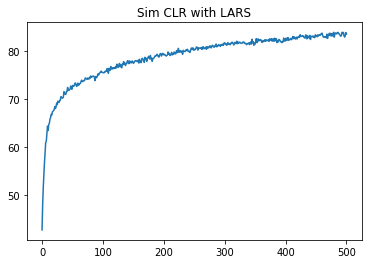

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_acc_1_epoch)
plt.title('Sim CLR with LARS')